In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from yellowbrick.regressor import ResidualsPlot, PredictionError

c:\work\py3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1. Exploratory Data Analysis

In [397]:
dft = pd.read_json('logins.json')

In [398]:
dft.head()
# dft.shape:(93142, 1)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [399]:
dft.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [400]:
dft['login_count'] = 1
dft= dft.set_index(pd.to_datetime(dft['login_time'], unit='s'))[['login_count']]

In [619]:
dft_15 = dft.resample('15min').sum()

,login_count
login_time,
1970-03-01 04:30:00,73


In [608]:
import matplotlib.dates as mdates
def pltfunc(x,y,data,title=None):
    fig, ax = plt.subplots(figsize=(15,5))
    _=ax.plot(x,y,color='crimson')
    months = mdates.MonthLocator()
    ax.xaxis.set_major_locator(months)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)
    plt.ylabel('Number of Logins',fontsize=18)
    plt.title(title,fontsize=18)
    plt.xticks(fontsize=14)

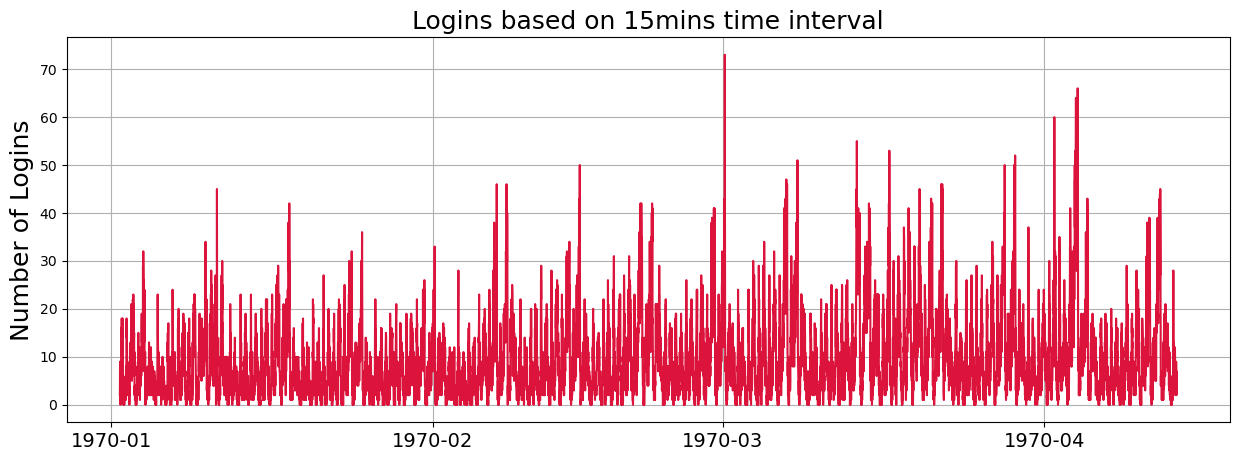

In [609]:
pltfunc(dft_15.index, dft_15.login_count, dft, 'Logins based on 15mins time interval')

In [620]:
dft_15[dft_15.login_count==dft_15.login_count.max()]

,login_count
login_time,
1970-03-01 04:30:00,73


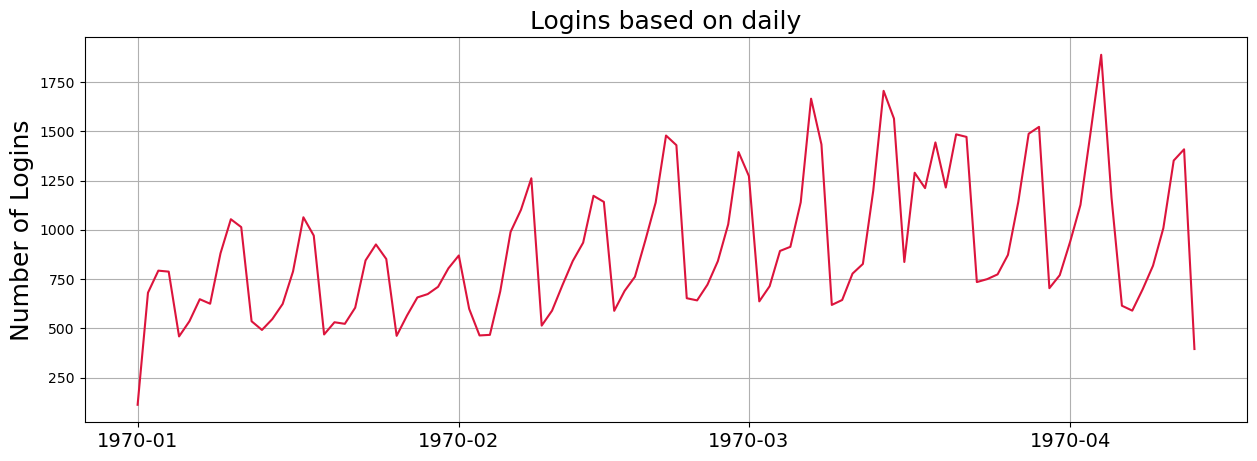

In [610]:
dft_d = dft.resample('D').sum()
pltfunc(dft_d.index, dft_d.login_count, dft, 'Logins based on daily')

In [613]:
dft_m = dft.resample('M').sum()
dft_m

,login_count
login_time,
1970-01-31,21239
1970-02-28,24673
1970-03-31,33723
1970-04-30,13507


* Acoording to the 15-minute time intervals and daily logins plots, the number of logins were getting increased from Jan to March and decrease in April, 1970. I found out that there was the maximum number of logins,73, on March 1st between 4:15 to 4:30.The lowest login_count among 4 months were April, 13507 logins. 

In [492]:
dft_h = dft.resample('H').sum()
dft_h['hour'] = [t.hour for t in dft_h.index]
dft_h['day'] = [t.dayofweek for t in dft_h.index]
dft_h['day'] = np.where(dft_h['day']>=4, 'weekend','weekday')

In [604]:
#dft_h.day.value_counts()
#dft_h.head()

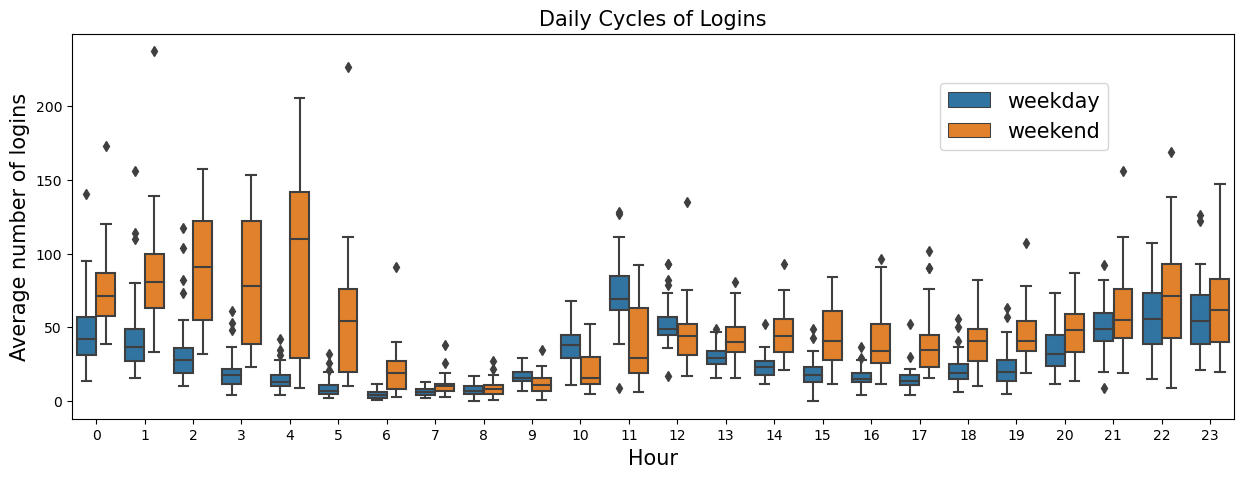

In [581]:
fig,ax = plt.subplots(figsize=(15,5))
sns.boxplot('hour','login_count',data=dft_h, hue = 'day')
ax.legend(bbox_to_anchor=(0.8,0.8,0.1, 0.1),fontsize=15)
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Average number of logins',fontsize=15)
plt.xticks(fontsize=10)
_=ax.set_title('Daily Cycles of Logins',fontsize=15)

In [582]:
daily_cycle = pd.pivot_table(dft_h, values = 'login_count', index='hour', columns='day', aggfunc=np.mean)
daily_cycle = daily_cycle.stack(level=['day'])
daily_cycle.name = 'average_num_logins'
daily_cycle = round(daily_cycle.reset_index())

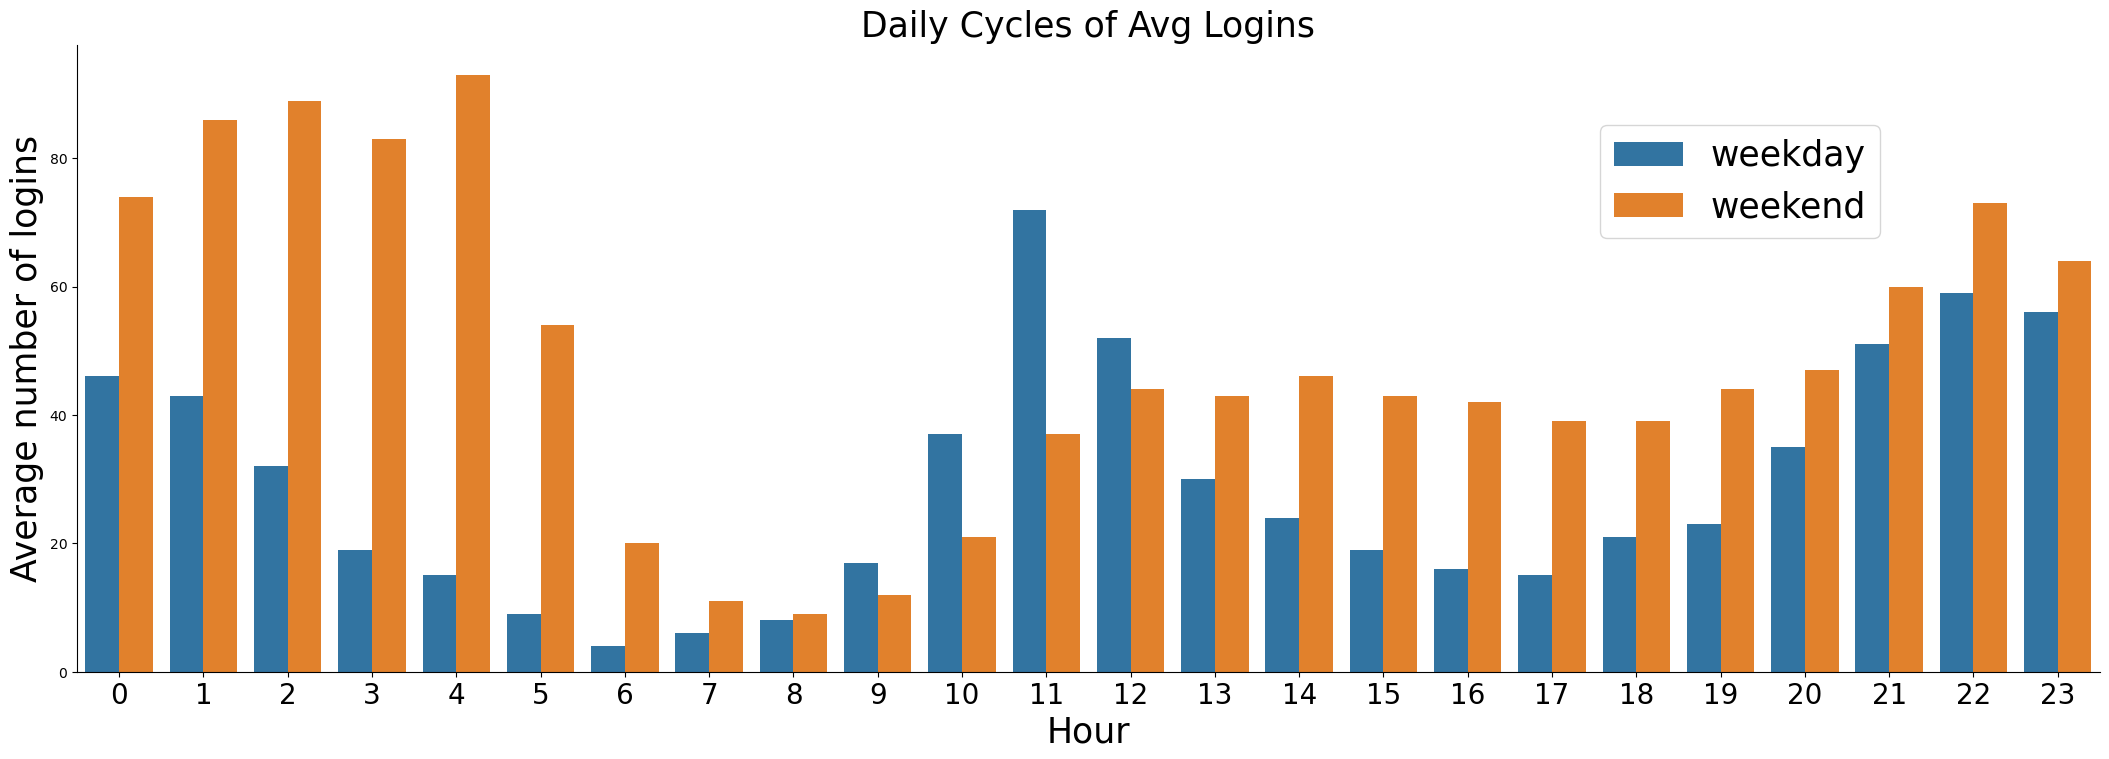

In [583]:
sns.catplot(x='hour', y='average_num_logins', data=daily_cycle, kind = 'bar', 
            hue='day',height=7, aspect=3, legend=False)
ax = plt.gca()
ax.legend(bbox_to_anchor=(0.8,0.8,0.1, 0.1),fontsize=25)
ax.set_xlabel('Hour',fontsize=25)
ax.set_ylabel('Average number of logins',fontsize=25)
plt.xticks(fontsize=20)
_=ax.set_title('Daily Cycles of Avg Logins',fontsize=25)

* I drew the 2 plots which were boxplots and barplots to represent the daily cycles of the number of logins. According to the average bar plot, I could see that people were actively login at midnight and the not active in the morning or daytime. It was interesting to see that the most active login time was 4am on weekends.The most popular login time on weekdays was 11 am. I could guess that people usually login during lunch time and before they go to bed on weekdays. In general, people login more on the weekend than weekday but they showed similar time series pattern. 
<br>
The boxplot also shows similar pattern with the bar plot. However, we should consider some extreme maximum values of the number of logins before generalizing the daily cycle based on the averag number.

## Part 2 -  Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


* Answer 1: I will choose the number of active Ultimates on weekdays as the key measure of success of this experiment. Especially the number of activy by hourly will be the key metric. Since the difference of active rate between Ultimate Gotham and Metropolis has happened on weekday, it will be fair to compare the new active rate on weekday. The the hourly data is required to compare between the active rate of two Utimates during the day and at night.   

* Answer 2: I will compare the number of active Utilmate Gotham or Utilmate Metropolis before reimbursing all toll costs to after the new plan. Presumably if I have the 3 months data that includes the hourly amount of Utilmate Gotham or Mtropolis before the reimbursement of tolls, I will gather the same utility data after operating the reimbursing plan for 3 months.   
<br>
H0: <br>
1) The mean of the number of active Utilmate Gotham is no difference before and after the new reimbusing plan
<br>
2)The mean of the number of active Utilmate Metropolis  is no difference before and after the new reimbusing plan
<br>
H1: The mean of difference exists
<br>
T-test seems to be proper to determine if there is a statistically significant difference between the two independent groups which are before and after the reimbusing plan. If the both p-values from the two tests are less than 0.05, I won't be able to reject the null hypotheses. Thus, I will say to the city operations team that the reimbusing plan doesn't really affect the encouraging driver partners to serve both cities. On the other hand, if both p-values from the tests are bigger than 0.05, the reimbusing plan has a significant effect on driver partners. 
If the p-values from the tests are not equal, I will perform additional feature engineering or utilizing different metrics.

## Part 3 -  Predictive modeling

In [264]:
df = pd.read_json('ultimate_data_challenge.json')

In [265]:
df.dtypes
df['ultimate_black_user']=df['ultimate_black_user'].astype(int)
df['signup_date'] = pd.DatetimeIndex(df['signup_date'])
df['last_trip_date'] = pd.DatetimeIndex(df['last_trip_date'])
df['user_days'] = (df['last_trip_date']-df['signup_date']).dt.days

## Handling outliers

In [268]:
df.shape

(50000, 13)

In [269]:
for i in df.columns:
    t = df[i].isnull().sum()
    if t !=0:
        print(f'The number of NA in {i} is {t}')

The number of NA in avg_rating_of_driver is 8122
The number of NA in phone is 396
The number of NA in avg_rating_by_driver is 201


In [270]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].replace(np.nan,round(df['avg_rating_of_driver'].mean(),2))
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].replace(np.nan,round(df['avg_rating_by_driver'].mean(),2))
df.dropna(subset=['phone'], inplace=True)

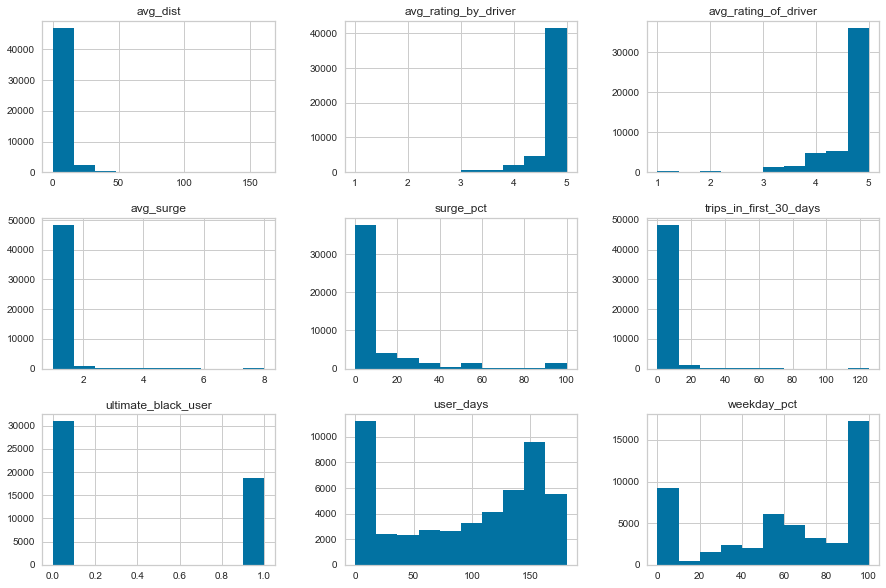

In [271]:
_=df.hist(figsize=(15,10))

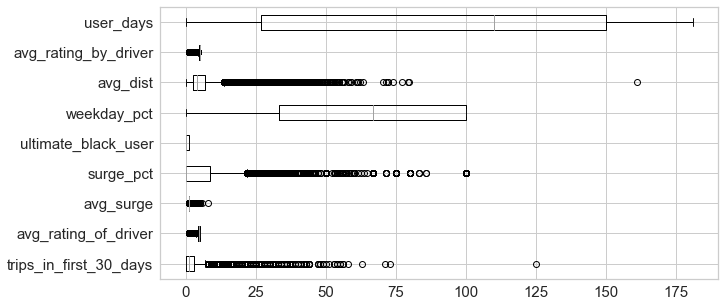

In [272]:
_=df.boxplot(grid=True, vert=False,fontsize=15,figsize=(10,5))

In [309]:
# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR =Q3 - Q1
# dfno =  df[~((df < (Q1 - 1.5 * IQR)) |(df> (Q3 + 1.5 * IQR))).any(axis=1)]
# _ =dfno.boxplot(grid=True, vert=False,fontsize=15, figsize=(10,5))
# dfno.shape
#df =dfno

In [310]:
#df['city'].value_counts(), df['phone'].value_counts()

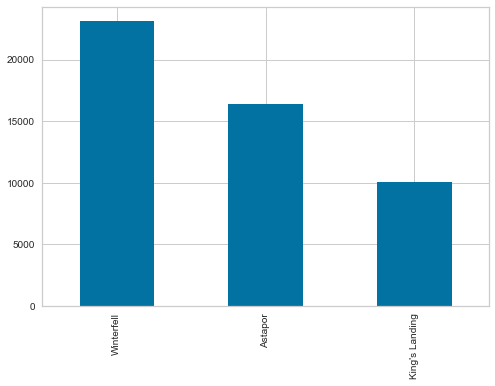

In [274]:
_=df['city'].value_counts().plot.bar()

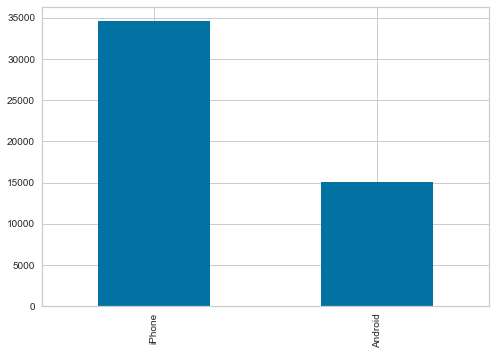

In [275]:
df['phone'].value_counts(dropna=False).plot.bar()

In [276]:
df = pd.get_dummies(df, columns = ['city', 'phone'])

## Feature Engineering

In [277]:
lastday = df['last_trip_date'].max()
ld = lastday - pd.Timedelta('30 days')
df['active']= (df['last_trip_date']>=ld).astype(int)

In [278]:
df['active'].value_counts()

0    30933
1    18671
Name: active, dtype: int64

## Correlation matrix

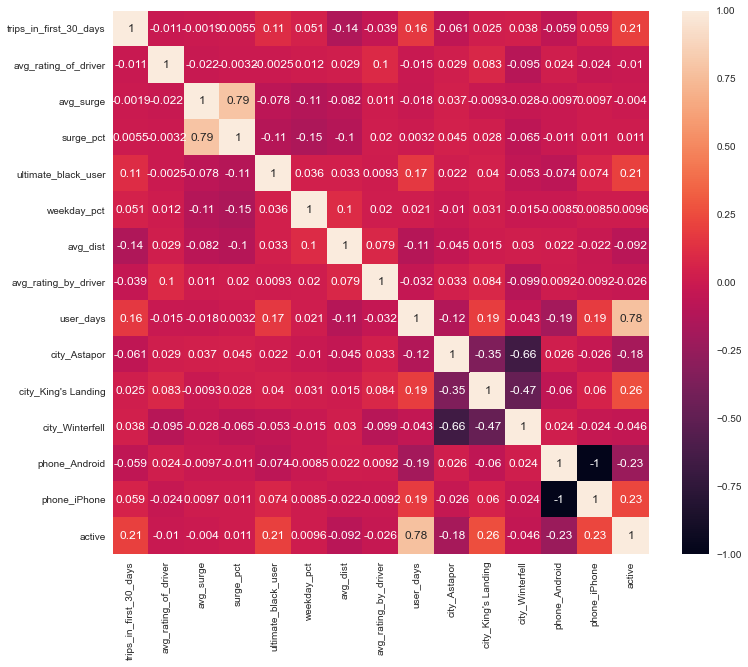

In [279]:
plt.figure(figsize=(12,10))
p=sns.heatmap(df.corr(), annot=True)

In [280]:
df.dtypes

trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
surge_pct                        float64
ultimate_black_user                int32
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
user_days                          int64
city_Astapor                       uint8
city_King's Landing                uint8
city_Winterfell                    uint8
phone_Android                      uint8
phone_iPhone                       uint8
active                             int32
dtype: object

In [60]:
cls1 = df[df['active']==1]
cls0 = df[df['active']==0]
cls0 = cls0.sample(n=10733, random_state=1)
df0 = pd.concat([cls0,cls1])
df0['active'].value_counts()

1    13705
0    10733
Name: active, dtype: int64

## Logistic Regression

In [783]:
# from sklearn.linear_model import LogisticRegression
# test_scoresl = ['test_scores']
# train_scoresl = ['train_scores']
# cls1 = df[df['active']==1]
# for i in range(1,10):
#     cls0 = df[df['active']==0]
#     cls0 = cls0.sample(n=10733, random_state=i)
#     df0 = pd.concat([cls0,cls1])
#     X = df0.drop(['active','last_trip_date','signup_date', 'phone_Android', 'surge_pct'],axis=1)
#     scaler = preprocessing.StandardScaler().fit(X)
#     X_scaled=scaler.transform(X) 
#     y= df0['active'].ravel()
#     X_train,X_test,y_train,y_test= train_test_split(X_scaled, y, test_size=0.25, random_state=1)
#     logreg = LogisticRegression()
#     logreg.fit(X_train, y_train)
#     train_scoresl.append(round(logreg.score(X_train, y_train),4))
#     test_scoresl.append(round(logreg.score(X_test, y_test),4))

In [799]:
from sklearn.linear_model import LogisticRegression
X = df.drop(['active','last_trip_date','signup_date', 'phone_Android', 'surge_pct'],axis=1)
scaler = preprocessing.StandardScaler().fit(X)
X_scaled=scaler.transform(X) 
y= df['active'].ravel()
X_train,X_test,y_train,y_test= train_test_split(X_scaled, y, test_size=0.25, random_state=1)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
tr_score = round(logreg.score(X_train, y_train),4)
tst_score = round(logreg.score(X_test, y_test),4)
model_name = 'logistics regression'
print(f'The best train and test scores in the {model_name} model:\n{tr_score}, {tst_score }')

The best train and test scores in the logistics regression model:
0.9595, 0.9598


In [786]:
# def bstscores(model_name,t1,t2):
#     t= list(zip(t1,t2))
#     matr,mate = 0,0
#     for i in t[1:]:
#         if mate<i[1]:
#             matr, mate = i[0], i[1]
#     print(f'The best train and test scores in the {model_name} model: {matr}, {mate}')
# bstscores('logistics regression', train_scoresl,test_scoresl)

In [800]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.301136
         Iterations: 35
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.546     
Dependent Variable: y                AIC:              22428.3544
Date:               2020-10-04 14:55 BIC:              22522.1200
No. Observations:   37203            Log-Likelihood:   -11203.   
Df Model:           10               LL-Null:          -24654.   
Df Residuals:       37192            LLR p-value:      0.0000    
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
       Coef.    Std.Err.     z    P>|z|     [0.025       0.975]  
-----------------------------------------------------------------
x1     0.6116      0.0257 23.8294 0.0000       0.5613      0.6619
x2     0.0050      0.0169  0.2939 0.7688      -0.0281      0.0380
x3     0.0892      0.0188  4.7532 0.

c:\work\py3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [801]:
pval_lst = list(map(lambda x:round(x,4), list(result.pvalues)))

In [802]:
df1 = pd.DataFrame({'Coefficient':list(result.params),'p-value':pval_lst},X.columns)
df1.sort_values(by = 'p-value',ascending=False).head(10)

,Coefficient,p-value
city_Astapor,-0.294697,1.0000
city_King's Landing,0.473741,1.0000
city_Winterfell,-0.103976,1.0000
avg_rating_of_driver,0.004953,0.7688
avg_dist,-0.028069,0.1094
avg_rating_by_driver,-0.037837,0.0318
weekday_pct,-0.068788,0.0001
trips_in_first_30_days,0.611616,0.0000
avg_surge,0.089227,0.0000
ultimate_black_user,0.363385,0.0000


In [ ]:
# Regularization: Ridge Regression(l2), adds penalty equivalent to square of the magnitude of coefficients
#Lsso Regression(l1), adds penalty to absolute value fo the magnitude of coefficients 

### Regularization: Lasso Regression

In [743]:
lasso_model = Lasso(random_state=123)
lasso_model .fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=123,
      selection='cyclic', tol=0.0001, warm_start=False)

In [803]:
X=df.drop(['active','last_trip_date','signup_date', 'phone_Android', 'surge_pct','city_Astapor',"city_King's Landing",'city_Winterfell'],axis=1)
scaler = preprocessing.StandardScaler().fit(X)
X_scaled=scaler.transform(X) 
X_train,X_test,y_train,y_test= train_test_split(X_scaled, y, test_size=0.25, random_state=1)
logreg0 = LogisticRegression()
logreg0.fit(X_train, y_train)
tr_score = round(logreg0.score(X_train, y_train),4)
tst_score = round(logreg0.score(X_test, y_test),4)
model_name = 'logistics regression'
print(f'The best train and test scores in the {model_name} model:\n{tr_score}, {tst_score }')

The best train and test scores in the logistics regression model:
0.9573, 0.9577


In [804]:
logit_model0=sm.Logit(y_train,X_train)
result=logit_model0.fit()
pval_lst = list(map(lambda x:round(x,4), list(result.pvalues)))
df1 = pd.DataFrame({'Coefficient':list(result.params),'p-value':list(pval_lst)},X.columns)

Optimization terminated successfully.
         Current function value: 0.317581
         Iterations 7


In [805]:
df1.sort_values(by = 'p-value',ascending=False).head(10)

,Coefficient,p-value
avg_dist,0.001334,0.9370
avg_rating_by_driver,-0.007362,0.6703
avg_rating_of_driver,0.028438,0.0837
weekday_pct,-0.049449,0.0038
trips_in_first_30_days,0.640752,0.0000
avg_surge,0.084850,0.0000
ultimate_black_user,0.334435,0.0000
user_days,2.494780,0.0000
phone_iPhone,0.346342,0.0000


In [797]:
X=X.drop(['avg_rating_of_driver','avg_dist'],axis=1)
scaler = preprocessing.StandardScaler().fit(X)
X_scaled=scaler.transform(X) 
X_train,X_test,y_train,y_test= train_test_split(X_scaled, y, test_size=0.25, random_state=1)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
tr_score = round(logreg.score(X_train, y_train),4)
tst_score = round(logreg.score(X_test, y_test),4)
model_name = 'logistics regression'
print(f'The best train and test scores in the {model_name} model:\n{tr_score}, {tst_score }')

The best train and test scores in the logistics regression model:
0.9571, 0.9574


In [798]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
df1 = pd.DataFrame({'Coefficient':list(result.params),'-value':list(result.pvalues)},X.columns)
df1

Optimization terminated successfully.
         Current function value: 0.317621
         Iterations 7


,Coefficient,-value
trips_in_first_30_days,0.639064,2.591968e-140
avg_surge,0.083830,3.788597e-06
ultimate_black_user,0.334701,1.439039e-83
weekday_pct,-0.049143,3.846497e-03
avg_rating_by_driver,-0.003735,8.273236e-01
user_days,2.494132,0.000000e+00
phone_iPhone,0.345612,1.771072e-100


## Random Forest

In [753]:
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }

In [836]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
X = df.drop(['active','last_trip_date','signup_date', 'phone_Android', 'surge_pct'],axis=1)
scaler = preprocessing.StandardScaler().fit(X)
X_scaled=scaler.transform(X) 
y= df['active'].ravel()
X_train,X_test,y_train,y_test= train_test_split(X_scaled, y, test_size=0.25, random_state=1)    
rfmodel_cv= GridSearchCV(RandomForestClassifier(),param_grid,cv=3)
rfmodel_cv.fit(X_train,y_train)

In [827]:
rf = RandomForestClassifier(max_depth=2, random_state=i) # The number of trees in the forest
rf.fit(X_train, y_train)
tr_score = round(rf.score(X_train, y_train),4)
tst_score = round(rf.score(X_test, y_test),4)
model_name = 'random forest'
print(f'The best train and test scores in the {model_name} model:\n{tr_score}, {tst_score }')

The best train and test scores in the random forest model:
0.9539, 0.9529


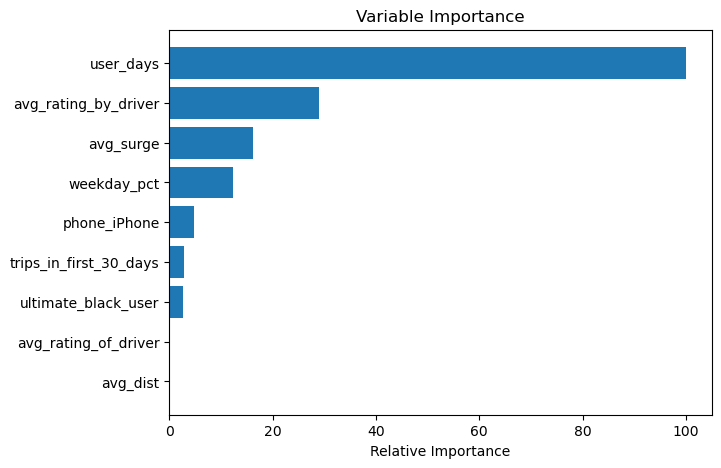

In [807]:
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]
pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(7,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [823]:
from xgboost import XGBClassifier
xg_clf = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=200, max_depth= 8)
xg_clf.fit(X_train, y_train)
xg_clf.score(X_train,y_train), xg_clf.score(X_test,y_test)

(0.9842485821035938, 0.9558906539795178)

### Confusion Matrix

* Class 1

| Model | Precision| Recall |Accuracy|
| --- | --- | --- | --- |
| Logistic Regressions | 0.97| 0.96|0.97|
| RandomForest | 0.97   | 0.95| 0.96|

In [832]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
logreg_pred = logreg0.predict(X_test)
confusion_matrixl = confusion_matrix(y_test,logreg_pred)
print(f'Logistic Regression:\n {confusion_matrixl}') 

Logistic Regression:
 [[7460  304]
 [ 221 4416]]


In [834]:
print(classification_report(y_test, logreg_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      7764
           1       0.94      0.95      0.94      4637

    accuracy                           0.96     12401
   macro avg       0.95      0.96      0.95     12401
weighted avg       0.96      0.96      0.96     12401



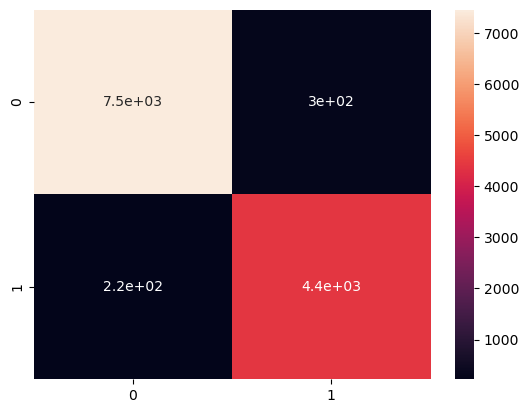

In [833]:
_=sns.heatmap(confusion_matrixl,annot=True)

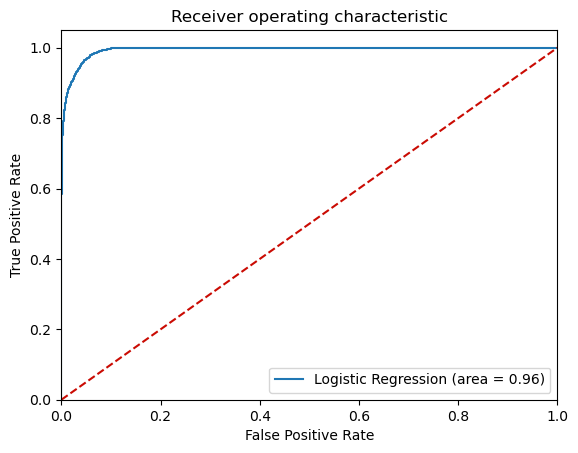

In [831]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logreg = logreg0
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [828]:
rf_pred = rf.predict(X_test)
confusion_matrixrf = confusion_matrix(y_test,regr_pred)
print(confusion_matrixreg) 

[[7442  322]
 [ 225 4412]]


In [829]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      7764
           1       0.92      0.96      0.94      4637

    accuracy                           0.95     12401
   macro avg       0.95      0.95      0.95     12401
weighted avg       0.95      0.95      0.95     12401



In [825]:
xg_pred = xg_clf.predict(X_test)
confusion_matrixxg = confusion_matrix(y_test,xg_pred)
print(confusion_matrixxg) 

[[7442  322]
 [ 225 4412]]


In [826]:
print(classification_report(y_test, regr_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7764
           1       0.93      0.95      0.94      4637

    accuracy                           0.96     12401
   macro avg       0.95      0.96      0.95     12401
weighted avg       0.96      0.96      0.96     12401

